In [1]:
import intake
import glob
import dask.distributed as dsk
import matplotlib.pyplot as plt
import xarray as xr
import cf_xarray as cfxr
import numpy as np
import xesmf as xe

import cmocean as cm
import cartopy.crs as ccrs

import cartopy.feature as cft
import matplotlib.path as mpath

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35803/status,
Dashboard: /proxy/35803/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33827,Workers: 0
Dashboard: /proxy/35803/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44117,Total threads: 1
Dashboard: /proxy/32999/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34159,


In [3]:
# Colours
from matplotlib.colors import to_rgba

colors = {'pan01_res': '#0000a2',
          'pan005_res': '#E84141',
          'pan01_pre' : '#18669C',
          'access_pre': 'tab:orange'}

def lighten(color, amount=0.4):
    c = np.array(to_rgba(color))
    return tuple(c[:3] + (1 - c[:3]) * amount)

In [4]:
lat_slice = slice(-79,-59)

# Importing data
pathsC_1 = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))[24:]
pathsM_1 = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month.nc'))

pathsC_2 = np.sort(glob.glob('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/outpu*/ocean/ocean_month.nc'))
pathsM_2 = np.sort(glob.glob('/scratch/x77/jn8053/access-om2/archive/01deg_jra55v13_ryf9091_21mbath_sofia_ssp126_prsc_rest/*/ocean/ocean_month.nc'))

In [5]:
def preprocess_1(ds):
    ds = ds[['salt_flux','salt_flux_added']].sel(yh=lat_slice) 
    return ds

cont_pan = xr.open_mfdataset(pathsC_1, preprocess = preprocess_1, chunks = 'auto')
melt_pan = xr.open_mfdataset(pathsM_1, preprocess = preprocess_1, chunks = 'auto')

def preprocess_2(ds):
    ds = ds[['sfc_salt_flux_ice','sfc_salt_flux_restore']].sel(yt_ocean=lat_slice) 
    return ds

cont_acc = xr.open_mfdataset(pathsC_2, preprocess = preprocess_2, chunks = 'auto')
melt_acc = xr.open_mfdataset(pathsM_2, preprocess = preprocess_2, chunks = 'auto')

In [6]:
# Time slice
cont_pan = cont_pan.sel(time=slice('2001-01-01','2010-12-31'))
melt_pan = melt_pan.sel(time=slice('2001-01-01','2010-12-31'))

cont_acc = cont_acc.sel(time=slice('1910-01-01','1919-12-31'))
melt_acc = melt_acc.sel(time=slice('1910-01-01','1919-12-31'))

In [7]:
ice_salt_pan_C = cont_pan['salt_flux'] - cont_pan['salt_flux_added']
ice_salt_pan_M = melt_pan['salt_flux'] - melt_pan['salt_flux_added']

ice_salt_acc_C = cont_acc['sfc_salt_flux_ice']
ice_salt_acc_M = melt_acc['sfc_salt_flux_ice']

In [8]:
ice_salt_pan_anom = ice_salt_pan_M - ice_salt_pan_C
ice_salt_acc_anom = ice_salt_acc_M - ice_salt_acc_C

In [9]:
# load area
area_old_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['areacello']
var_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_month_z.nc')['so'].isel(z_l=0,time=0)
area_corr_1 = area_old_1*(var_1*0 +1)

area_old_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['area_t']
var_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean.nc')['salt'].isel(st_ocean=0,time=0).sel(yt_ocean=slice(-79,-39))
area_corr_2 = area_old_2*(var_2*0 +1)

In [10]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

depth_1 = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask_1 = (0 * depth_1).fillna(1)
depth_shelf_1, shelf_mask_1 = shelf_mask_isobath(depth_1, 'mom6_01')

depth_2 = xr.open_dataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_21mbath/output012/ocean/ocean_grid.nc')['ht']
land_mask_2 = (0 * depth_2).fillna(1)
depth_shelf_2, shelf_mask_2 = shelf_mask_isobath(depth_2, 'mom5')

In [11]:
shelf_ice_pan_C = (area_corr_1 * ice_salt_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
shelf_ice_pan_M = (area_corr_1 * ice_salt_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

shelf_ice_acc_C = (area_corr_2 * ice_salt_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
shelf_ice_acc_M = (area_corr_2 * ice_salt_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

In [12]:
shelf_ice_pan_C = shelf_ice_pan_C.load()
shelf_ice_pan_M = shelf_ice_pan_M.load()

In [13]:
shelf_ice_acc_C = shelf_ice_acc_C.load()
shelf_ice_acc_M = shelf_ice_acc_M.load()

In [14]:
shelf_ice_pan_anom = shelf_ice_pan_M - shelf_ice_pan_C
shelf_ice_acc_anom = shelf_ice_acc_M - shelf_ice_acc_C

In [15]:
shelf_ice_pan_anom = shelf_ice_pan_anom.to_series()['2001-01-01':'2010-12-16']
shelf_ice_acc_anom = shelf_ice_acc_anom.to_series()['1910-01-01':'1919-12-16']

In [16]:
shelf_ice_pan_rm = shelf_ice_pan_anom.rolling(window=12, center=True).mean()
shelf_ice_acc_rm = shelf_ice_acc_anom.rolling(window=12, center=True).mean()

<Axes: xlabel='time'>

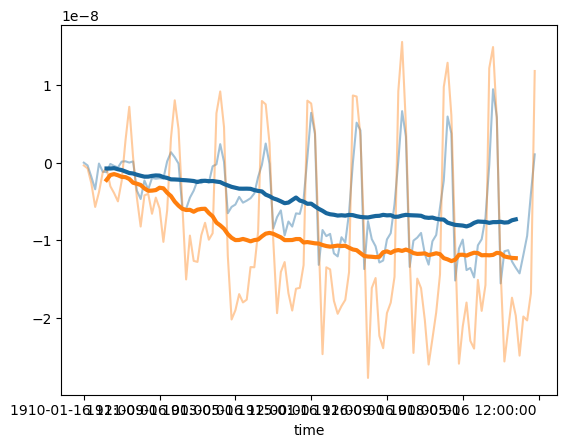

In [17]:
shelf_ice_pan_anom.plot(alpha = 0.4, color = colors['pan01_pre'])
shelf_ice_acc_anom.plot(alpha = 0.4, color = colors['access_pre'])
shelf_ice_pan_rm.plot(color = colors['pan01_pre'], linewidth=3)
shelf_ice_acc_rm.plot(color = colors['access_pre'], linewidth =3)

For access we have:
SSSi = 1/0.005

For panant we have:
ICE_BULK_SALINITY = 0.0
ICE_RELATIVE_SALINITY = 0.1

This is in g/kg so need to convert.

So SSSi = 1/( (SSS * 0.1) / 1000)

In [18]:
# Import surface salinity from panan
pathsC_1a = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month_z.nc'))[24:]
pathsM_1a = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ocean_month_z.nc'))

def preprocess_1a(ds):
    ds = ds[['so']].isel(z_l=0).sel(yh=lat_slice) 
    return ds

cont_pan_a = xr.open_mfdataset(pathsC_1a, preprocess = preprocess_1a, chunks = 'auto')
melt_pan_a = xr.open_mfdataset(pathsM_1a, preprocess = preprocess_1a, chunks = 'auto')

In [19]:
pan_SSS_C = cont_pan_a['so']
pan_SSS_M = melt_pan_a['so']

In [20]:
SSSi_acc = 1/0.005
SSSi_pan_C = 1/( (pan_SSS_C * 0.1) / 1000)
SSSi_pan_M = 1/( (pan_SSS_M * 0.1) / 1000)

In [21]:
SSSi_pan_C.min().load()

<xarray.DataArray 'so' ()> Size: 4B
array(272.14148, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413

In [22]:
SSSi_pan_C.max().load()

<xarray.DataArray 'so' ()> Size: 4B
array(1197.6676, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413

In [23]:
SSSi_pan_C_test = ( (pan_SSS_C * 0.1) / 1000)
SSSi_pan_M_test = ( (pan_SSS_M * 0.1) / 1000)

In [24]:
SSSi_pan_C_test.min().load()

<xarray.DataArray 'so' ()> Size: 4B
array(0.00083496, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413

In [26]:
SSSi_pan_M_test.max().load()

<xarray.DataArray 'so' ()> Size: 4B
array(0.00359071, dtype=float32)
Coordinates:
    z_l      float64 8B 0.5413

In [27]:
FW_ice_pan_C = -(ice_salt_pan_C*1000)/SSSi_pan_C
FW_ice_pan_M = -(ice_salt_pan_M*1000)/SSSi_pan_M
FW_ice_acc_C = -(ice_salt_acc_C*1000)/SSSi_acc
FW_ice_acc_M = -(ice_salt_acc_M*1000)/SSSi_acc

In [28]:
FW_shelf_ice_pan_C = (area_corr_1 * FW_ice_pan_C.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])
FW_shelf_ice_pan_M = (area_corr_1 * FW_ice_pan_M.where(shelf_mask_1 == 1)).sum(['xh', 'yh']) / area_corr_1.where(shelf_mask_1 == 1).sum(['xh', 'yh'])

FW_shelf_ice_acc_C = (area_corr_2 * FW_ice_acc_C.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])
FW_shelf_ice_acc_M = (area_corr_2 * FW_ice_acc_M.where(shelf_mask_2 == 1)).sum(['xt_ocean', 'yt_ocean']) / area_corr_2.where(shelf_mask_2 == 1).sum(['xt_ocean', 'yt_ocean'])

In [29]:
FW_shelf_ice_pan_anom = FW_shelf_ice_pan_M - FW_shelf_ice_pan_C
FW_shelf_ice_acc_anom = FW_shelf_ice_acc_M - FW_shelf_ice_acc_C

In [30]:
FW_shelf_ice_pan_C = FW_shelf_ice_pan_C.load()

In [31]:
FW_shelf_ice_pan_M = FW_shelf_ice_pan_M.load()

In [32]:
FW_shelf_ice_acc_C = FW_shelf_ice_acc_C.load()

In [33]:
FW_shelf_ice_acc_M = FW_shelf_ice_acc_M.load()

In [34]:
FW_shelf_ice_pan_anom = FW_shelf_ice_pan_anom.load()

In [35]:
FW_shelf_ice_acc_anom = FW_shelf_ice_acc_anom.load()

In [36]:
FW_shelf_ice_pan_C_new = FW_shelf_ice_pan_C.to_series()['2001-01-16':'2010-12-16']
FW_shelf_ice_pan_M_new = FW_shelf_ice_pan_M.to_series()['2001-01-16':'2010-12-16']
FW_shelf_ice_acc_C_new = FW_shelf_ice_acc_C.to_series()['2001-01-16':'2010-12-16']
FW_shelf_ice_acc_M_new = FW_shelf_ice_acc_M.to_series()['2001-01-16':'2010-12-16']
FW_shelf_ice_pan_anom_new = FW_shelf_ice_pan_anom.to_series()['2001-01-16':'2010-12-16']
FW_shelf_ice_acc_anom_new = FW_shelf_ice_acc_anom.to_series()['1910-01-16':'1919-12-16']

In [37]:
FW_shelf_ice_pan_anom_rm = FW_shelf_ice_pan_anom_new.rolling(window=12, center=True).mean()
FW_shelf_ice_acc_anom_rm = FW_shelf_ice_acc_anom_new.rolling(window=12, center=True).mean()

<Axes: xlabel='time'>

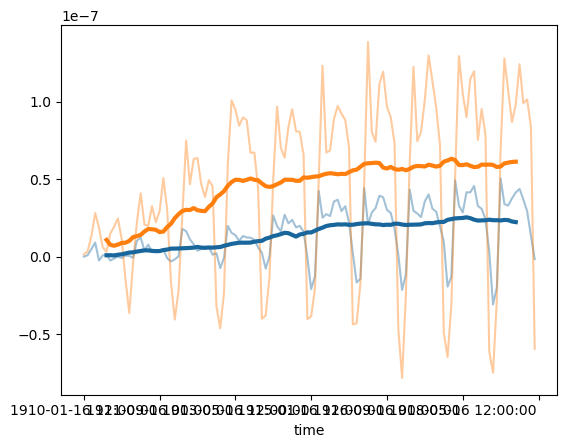

In [38]:
FW_shelf_ice_pan_anom_new.plot(alpha = 0.4, color = colors['pan01_pre'])
FW_shelf_ice_acc_anom_new.plot(alpha = 0.4, color = colors['access_pre'])
FW_shelf_ice_pan_anom_rm.plot(color = colors['pan01_pre'], linewidth=3)
FW_shelf_ice_acc_anom_rm.plot(color = colors['access_pre'], linewidth =3)

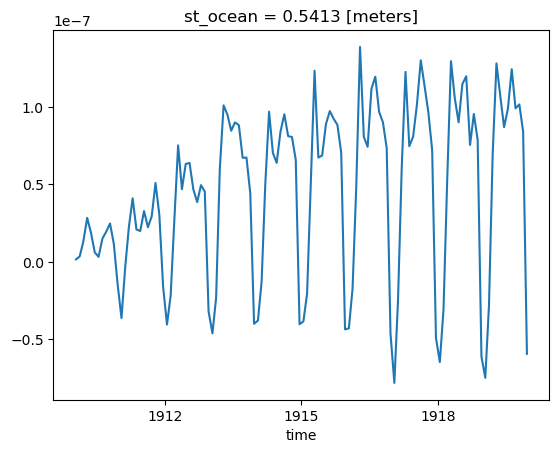

In [39]:
(FW_shelf_ice_acc_M - FW_shelf_ice_acc_C).plot()

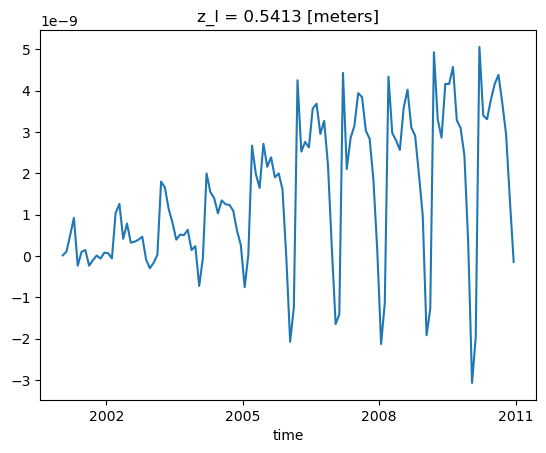

In [40]:
((FW_shelf_ice_pan_M - FW_shelf_ice_pan_C)*0.1).plot()

In [41]:
FW_shelf_ice_pan_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_corr_C_prescribed_pan01.nc')
FW_shelf_ice_pan_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_corr_M_prescribed_pan01.nc')
FW_shelf_ice_acc_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_corr_C_prescribed_access.nc')
FW_shelf_ice_acc_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/restoring_checks/icesalt_asFWF_corr_M_prescribed_access.nc')